In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
from functions import functions
import scipy
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML

In [8]:
spy = yf.download("SPY", start = "2000-01-01", end = datetime.today().strftime("%Y-%m-%d"))

[*********************100%%**********************]  1 of 1 completed


#### Trend Following

In [7]:
trend_following_sig = port1[["SPX Index"]].loc[:'2010-12-31'].copy()
trend_following_sig

,SPX Index
date,
2000-01-03,1455.22
2000-01-04,1399.42
2000-01-05,1402.11
2000-01-06,1403.45
2000-01-07,1441.47
...,...
2010-12-27,1257.54
2010-12-28,1258.51
2010-12-29,1259.78


Text(0.5, 0.98, 'Trend Following (50DMA)')

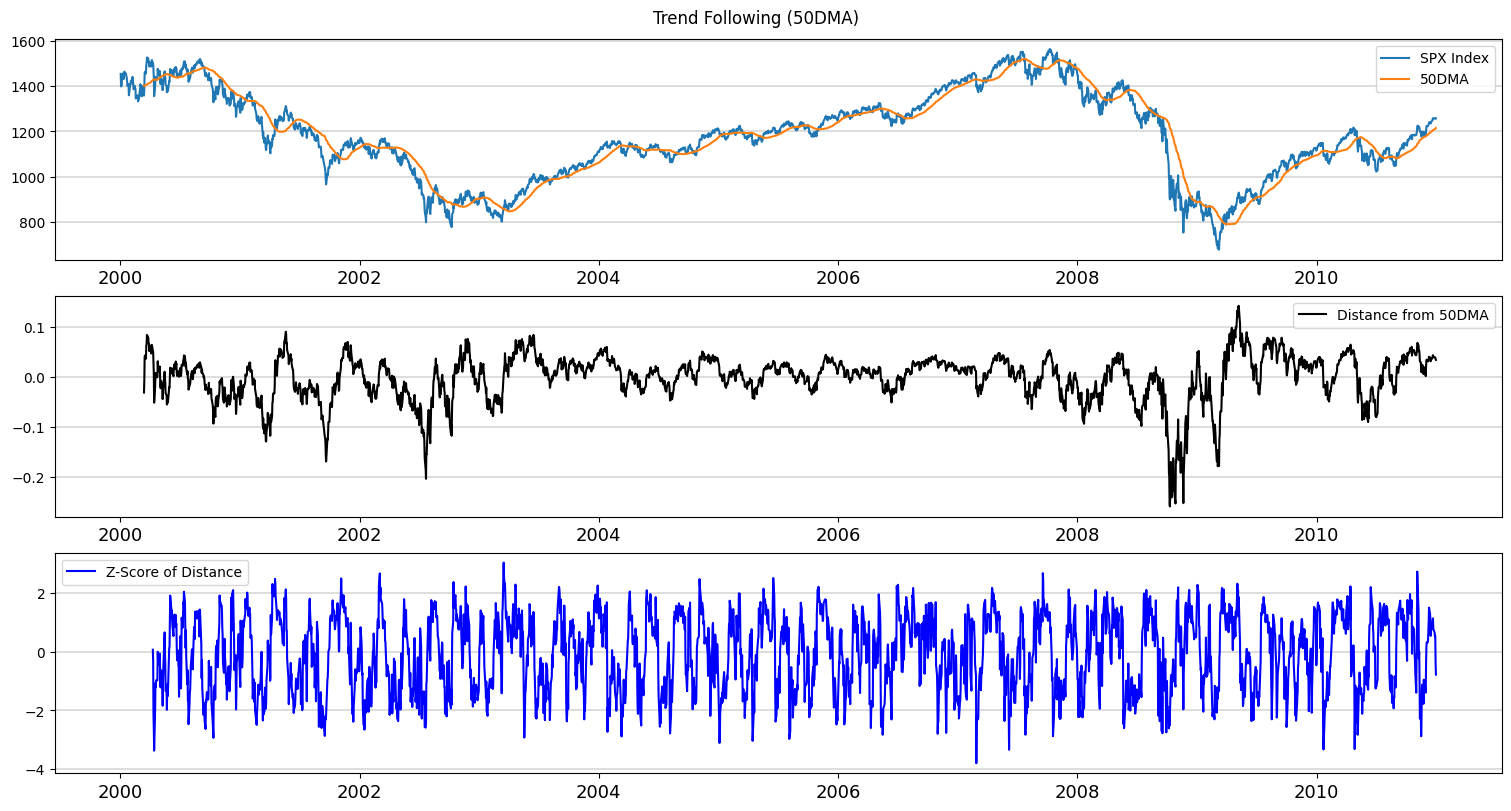

In [8]:
trend_following_sig["50DMA"] = trend_following_sig[["SPX Index"]].rolling(50).mean()
trend_following_sig["dist_50dma"] = (trend_following_sig["SPX Index"] / trend_following_sig["50DMA"])  - 1
z_50dma_dist_obj = trend_following_sig["dist_50dma"].rolling(20)
z_50dma_dist_z = (trend_following_sig["dist_50dma"] - z_50dma_dist_obj.mean()) / z_50dma_dist_obj.std()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["SPX Index"], label = "SPX Index")
ax[0].plot(trend_following_sig["50DMA"], label = "50DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_50dma"], label = "Distance from 50DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].plot(z_50dma_dist_z, label = "Z-Score of Distance", color = "blue")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (50DMA)")

Text(0.5, 0.98, 'Trend Following (200DMA)')

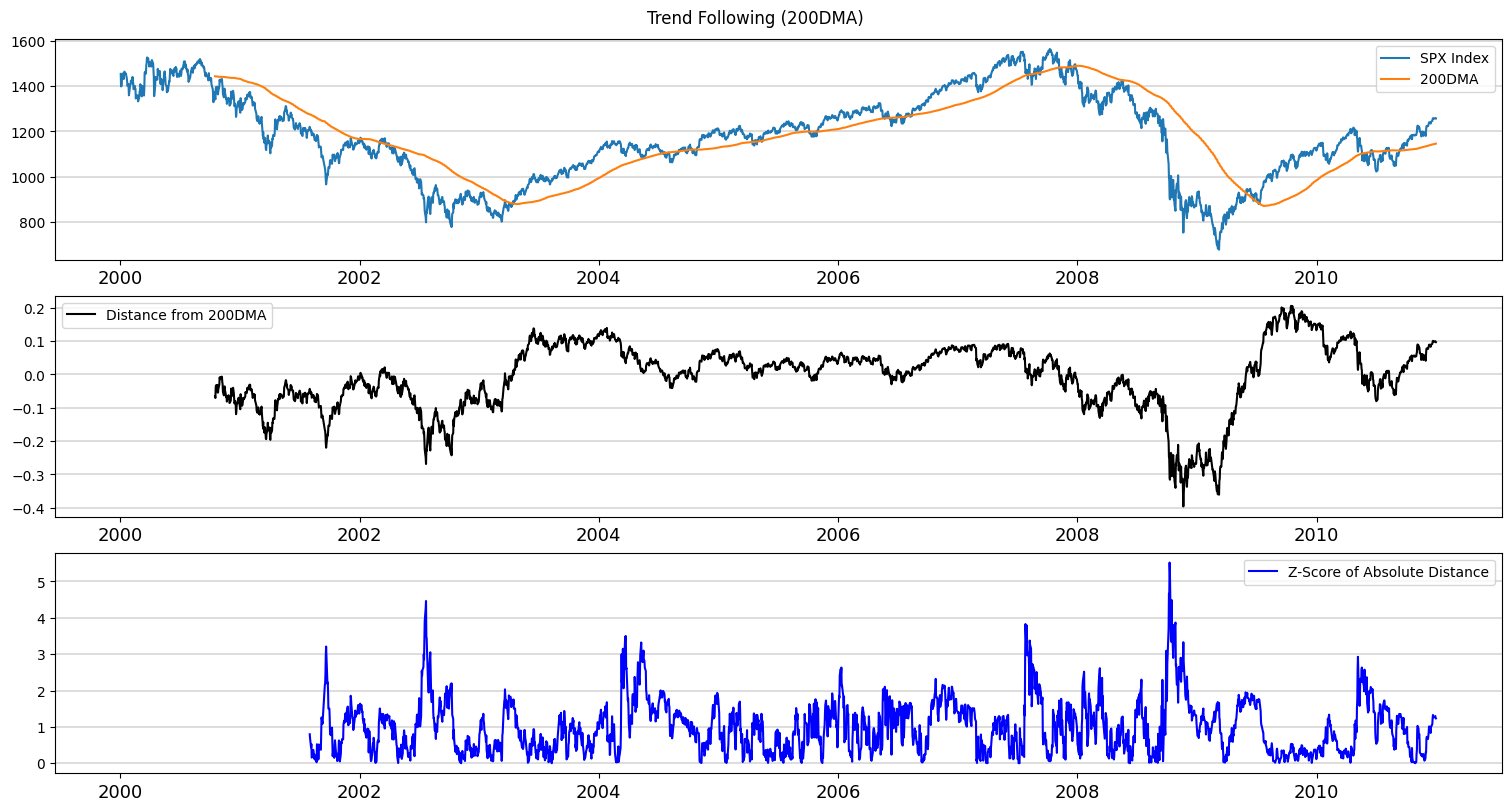

In [9]:
trend_following_sig["200DMA"] = trend_following_sig[["SPX Index"]].rolling(200).mean()
trend_following_sig["dist_200dma"] = (trend_following_sig["SPX Index"] / trend_following_sig["200DMA"])  - 1
z_200dma_dist_obj = trend_following_sig["dist_200dma"].abs().rolling(200)
trend_following_sig["Z"] = (trend_following_sig["dist_200dma"].abs() - z_200dma_dist_obj.mean()) / z_200dma_dist_obj.std()

# Create signal
trend_following_sig["Direction"] = np.where(trend_following_sig.dist_200dma >= 0, 1, -1)
# trend_following_sig["Size"] = np.where(trend_following_sig.Z > 1, np.where(trend_following_sig.Z > 2, np.where(trend_following_sig.Z > 2, np.where(trend_following_sig.Z > 3, 3, 5), 3), 2), 1)

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["SPX Index"], label = "SPX Index")
ax[0].plot(trend_following_sig["200DMA"], label = "200DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_200dma"], label = "Distance from 200DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

ax[2].plot(trend_following_sig.Z.abs(), label = "Z-Score of Absolute Distance", color = "blue")
# ax[2].plot(trend_following_sig.Size, label = "Position Sizing", linestyle = "dotted", color = "red")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (200DMA)")

### Basic Momentum Strategy

In [20]:
px_mom = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 1, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_3 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 3, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_6 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 6, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")

/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')


In [21]:
px_mom ['Signal'] = np.where(px_mom.Mth_Prior_1_Return >= 0, 1, 0)
px_mom_3['Signal'] = np.where(px_mom_3.Mth_Prior_3_Return >= 0, 1, 0)
px_mom_6['Signal'] = np.where(px_mom_6.Mth_Prior_6_Return >= 0, 1, 0)

sig_1_mo = px_mom.Signal
sig_1_mo.name = 'PX_Mom_1'
sig_3_mo = px_mom_3.Signal
sig_3_mo.name = 'PX_Mom_3'
sig_6_mo = px_mom_6.Signal
sig_6_mo.name = 'PX_Mom_6'

all_px_mom_sig = pd.concat([sig_1_mo, sig_3_mo, sig_6_mo], axis=1)
all_px_mom_sig['Sig_Strength'] = all_px_mom_sig.sum(axis=1)
all_px_mom_sig['Sig_Strength_Adj'] = all_px_mom_sig['Sig_Strength'].shift(1)
all_px_mom_sig['SPY_ret'] = spy['Adj Close'].pct_change()
all_px_mom_sig.dropna(inplace=True)
all_px_mom_sig['Positioning'] = all_px_mom_sig['Sig_Strength_Adj'].map({0 : 0.1, 1 : 0.4, 2 : 0.6, 3: 0.9})
all_px_mom_sig['Portfolio'] = all_px_mom_sig['Positioning'] * all_px_mom_sig['SPY_ret']
all_px_mom_sig

,PX_Mom_1,PX_Mom_3,PX_Mom_6,Sig_Strength,Sig_Strength_Adj,SPY_ret,Positioning,Portfolio
Date,,,,,,,,
2000-07-03,0,0.0,1.0,1.0,1.0,0.013766,0.4,0.005507
2000-07-05,0,0.0,1.0,1.0,1.0,-0.018035,0.4,-0.007214
2000-07-06,0,0.0,1.0,1.0,1.0,0.007779,0.4,0.003111
2000-07-07,1,0.0,1.0,2.0,1.0,0.016081,0.4,0.006432
2000-07-10,1,0.0,1.0,2.0,2.0,-0.001688,0.6,-0.001013
...,...,...,...,...,...,...,...,...
2010-12-27,1,1.0,1.0,3.0,3.0,0.000398,0.9,0.000358
2010-12-28,1,1.0,1.0,3.0,3.0,0.001432,0.9,0.001289
2010-12-29,1,1.0,1.0,3.0,3.0,0.000715,0.9,0.000644


In [25]:
functions.exportPerformanceMetrics(all_px_mom_sig["Portfolio"], all_px_mom_sig["SPY_ret"])

,Strategy,Benchmark
Performance Metrics (2000-07-03 till 2010-12-31),,
CAGR %,1.56%,0.43%
Volatility,9.02%,21.84%
Sharpe Ratio,0.17,0.02
Max Drawdown %,-24.87%,-55.19%
Return/MaxDrawdown,0.06,0.01


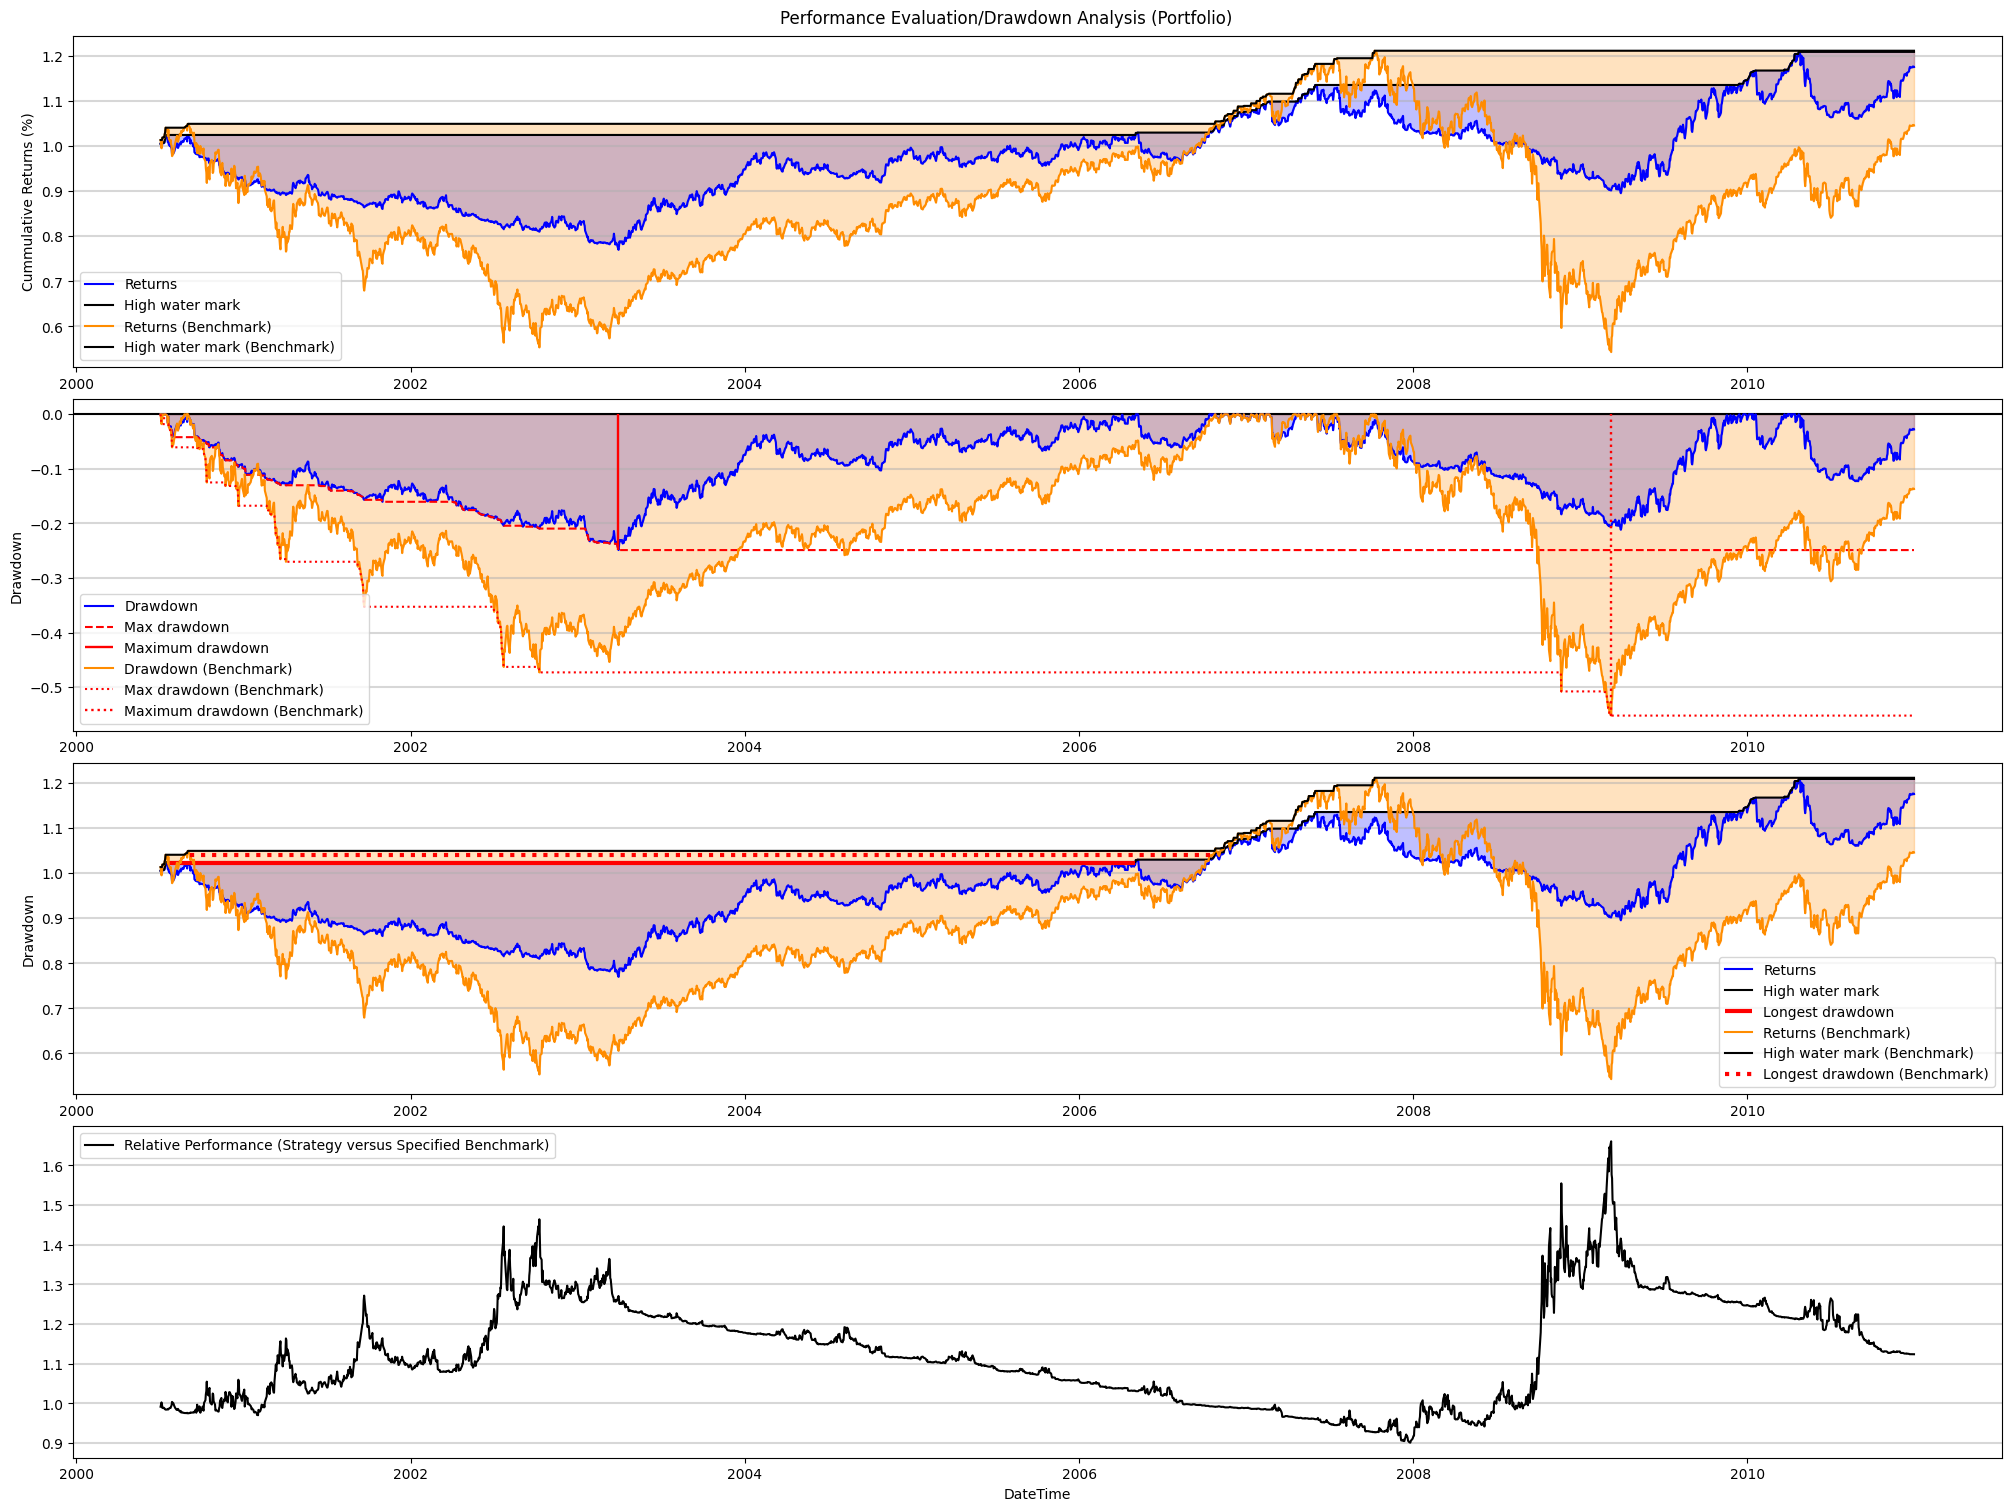

In [28]:
functions.drawdownCharts(all_px_mom_sig["Portfolio"], benchmark = all_px_mom_sig["SPY_ret"], includeBenchmark = True, showPlot=True)

In [39]:
nav_numbers = pd.read_excel("nav_sample.xlsx")
avm = nav_numbers[["Date_Strat", "AVM GOF A"]].dropna()
avm.rename(columns = {'Date_Strat':'Date'}, inplace=True)
avm.set_index('Date', inplace=True)
bnchmk = nav_numbers[["Date_Indx", "BHMACR Index Adj"]].dropna()
bnchmk.rename(columns = {'Date_Indx':'Date'}, inplace=True)
bnchmk.set_index('Date', inplace=True)
nav_numbers

,Date_Strat,AVM GOF A,Date_Indx,BHMACR Index,BHMACR Return,BHMACR Index Adj,BHMACR Return Check
0,2016-10-31,100.00,2013-12-31,1000.00,NaN,NaN,NaN
1,2016-11-30,98.81,2014-01-31,989.10,-1.090000,NaN,NaN
2,2016-12-30,100.67,2014-02-28,1002.91,1.396219,NaN,NaN
3,2017-01-31,102.04,2014-03-31,993.89,-0.899383,NaN,NaN
4,2017-02-28,104.36,2014-04-30,994.63,0.074455,NaN,NaN
...,...,...,...,...,...,...,...
112,NaT,NaN,2023-04-28,1219.02,0.470613,117.328534,0.470613
113,NaT,NaN,2023-05-31,1214.66,-0.357664,116.908891,-0.357664
114,NaT,NaN,2023-06-30,1228.82,1.165758,118.271767,1.165758
115,NaT,NaN,2023-07-31,1238.48,0.786120,119.201525,0.786120


In [63]:
functions.exportPerformanceMetrics(avm['AVM GOF A'].pct_change().dropna(), bnchmk['BHMACR Index Adj'].pct_change().dropna())

,Strategy,Benchmark
Performance Metrics (2016-11-30 till 2023-08-31),,
CAGR %,8.70%,2.44%
Volatility,4.70%,4.74%
Sharpe Ratio,1.85,0.51
Max Drawdown %,-7.89%,-9.21%
Return/MaxDrawdown,1.10,0.26


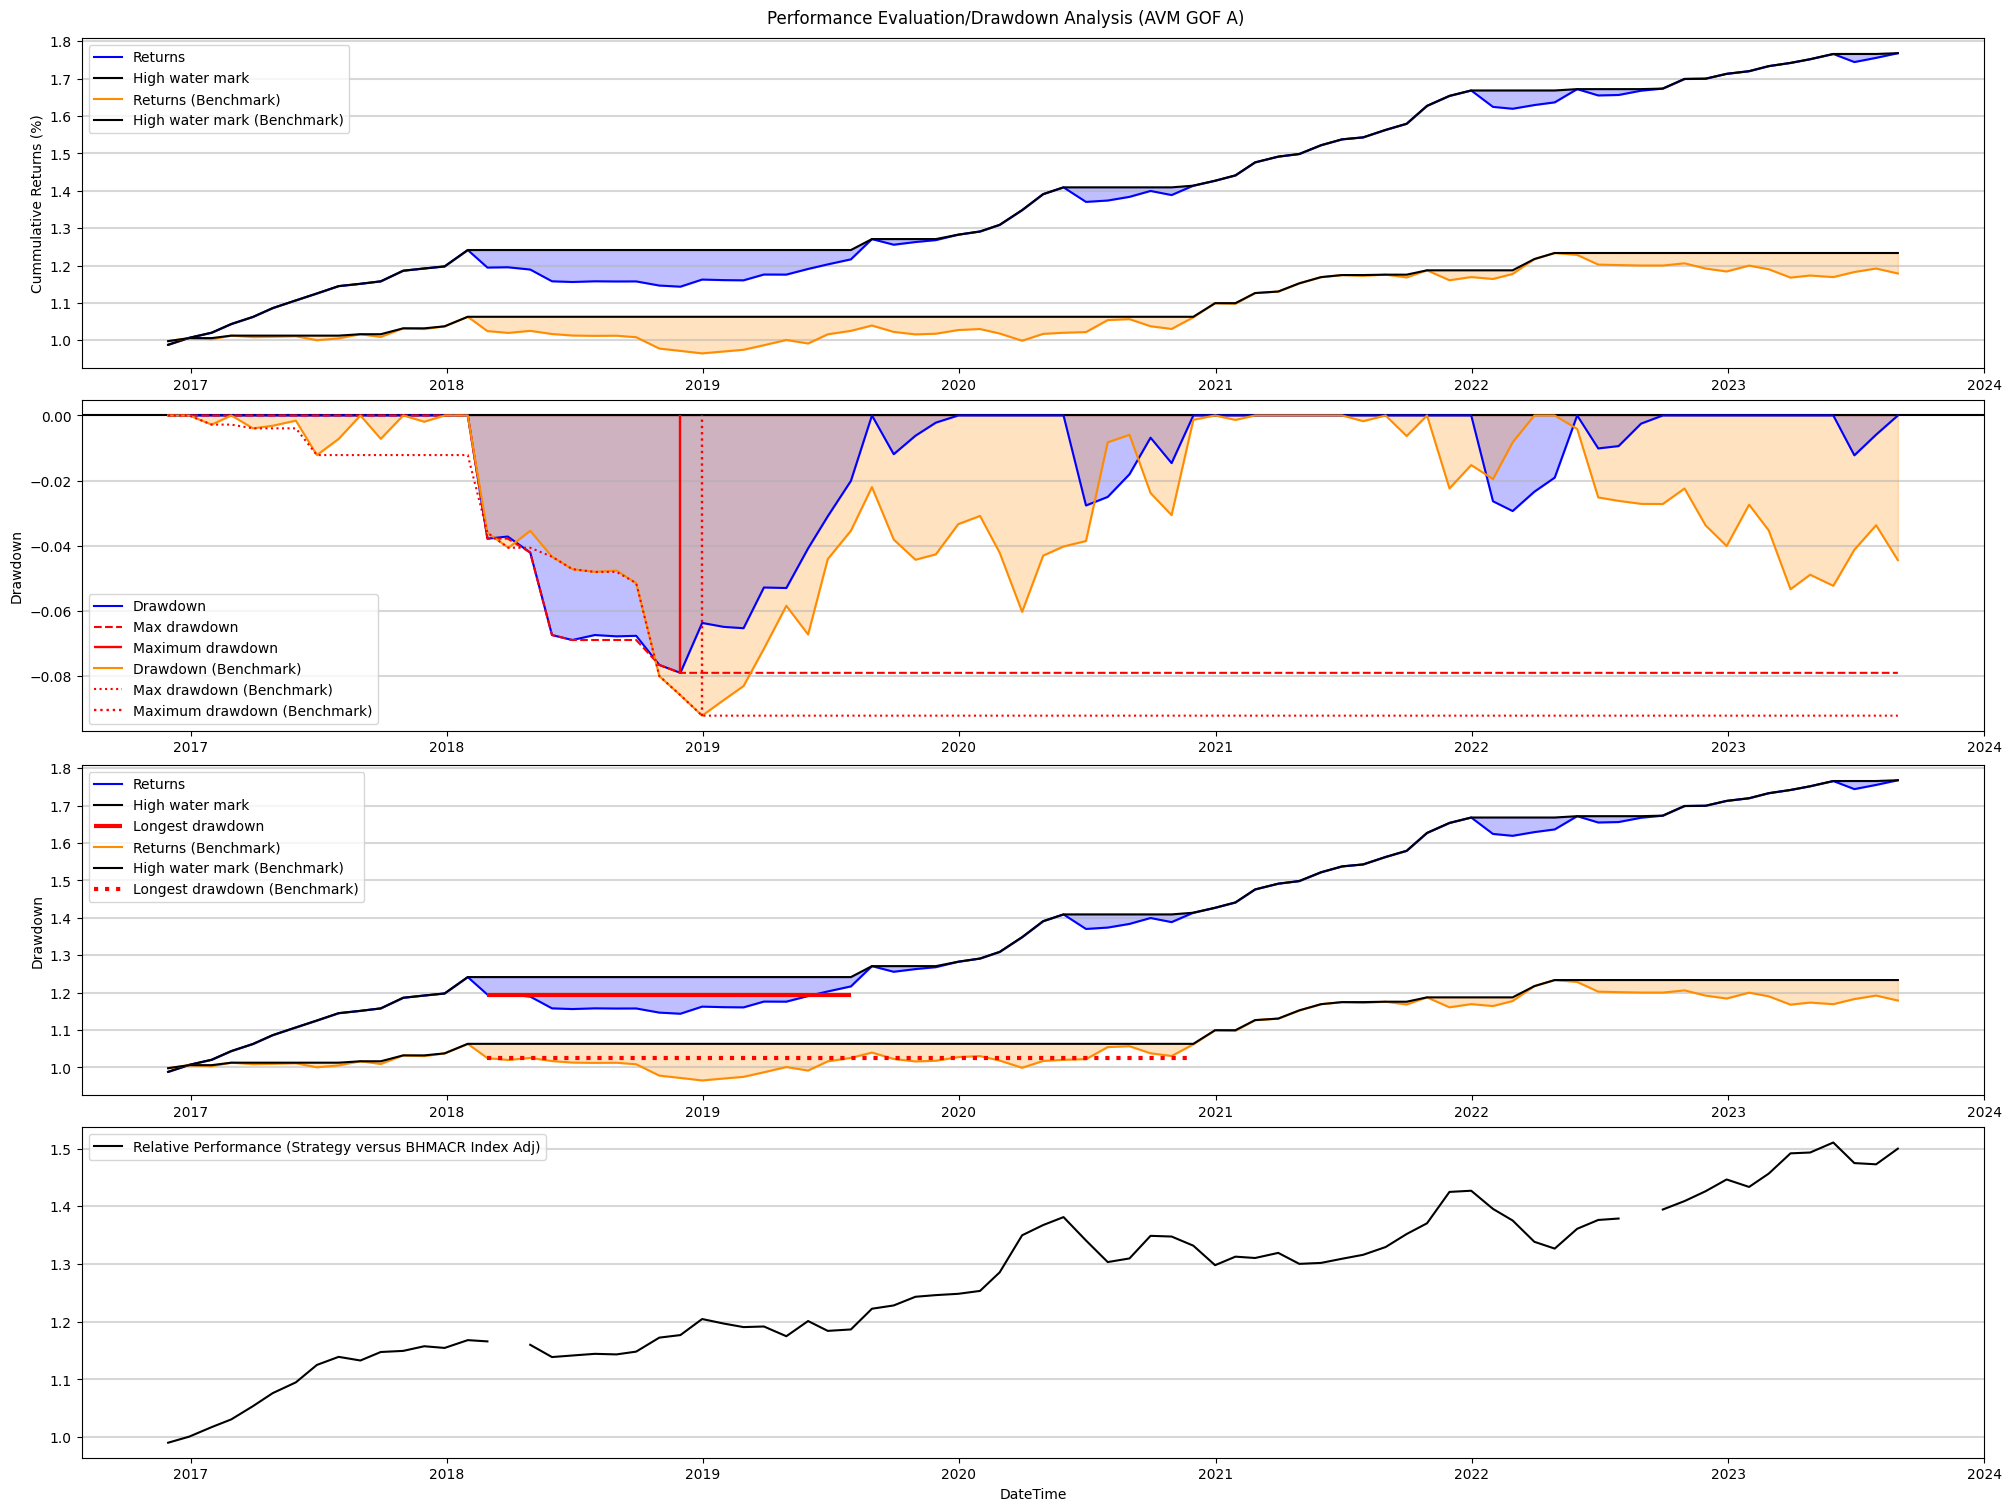

In [53]:
functions.drawdownCharts(avm['AVM GOF A'].pct_change(), bnchmk['BHMACR Index Adj'].pct_change(), includeBenchmark=True, showPlot=True)